In [13]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import pytesseract
from PIL import Image
from paddleocr import PaddleOCR

In [58]:
dataset_path = r"C:\Users\hssin\Downloads\dataset"  
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    print(f"Class: {folder}, Number of images: {len(os.listdir(folder_path))}")


Class: Bulletin_de_soin, Number of images: 1469
Class: Ordonnance, Number of images: 569
Class: Other, Number of images: 1467


In [60]:
template_path = r"C:\Users\hssin\Downloads\template"
input_folder = r"C:\Users\hssin\Downloads\dataset\Bulletin_de_soin"
#output_folder = r"C:\Users\hssin\Downloads\sizeset\Bulletin_de_soin"

In [15]:
def load_templates_from_folder(folder):
    """
    Load all template images from the specified folder.
    """
    images = {}
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images[filename] = img
    return images

In [17]:
def show_image(image, title="Image"):
    """
    Display an image using matplotlib.
    """
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis("off")
    plt.show()

In [19]:
def find_best_template(test_image, templates):
    """Find the best-matching template using SIFT."""
    sift = cv2.SIFT_create()
    keypoints2, descriptors2 = sift.detectAndCompute(test_image, None)
    
    best_match = None
    best_match_count = 0
    best_template_name = None
    
    for filename, template in templates.items():
        keypoints1, descriptors1 = sift.detectAndCompute(template, None)
        if descriptors1 is None or descriptors2 is None:
            continue
        
        flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
        matches = flann.knnMatch(descriptors1, descriptors2, k=2)
        
        good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
        if len(good_matches) > best_match_count:
            best_match_count = len(good_matches)
            best_match = template
            best_template_name = filename
    
    return best_match, best_template_name

In [21]:
def align_image(test_image, template):
    """Align the test image with the template using SIFT and homography."""
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(template, None)
    keypoints2, descriptors2 = sift.detectAndCompute(test_image, None)
    
    if descriptors1 is None or descriptors2 is None or len(keypoints1) < 10 or len(keypoints2) < 10:
        print("Not enough keypoints for alignment. Using original image.")
        return test_image
    
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    if len(good_matches) >= 10:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
        if H is not None:
            h, w = template.shape
            aligned_image = cv2.warpPerspective(test_image, H, (w, h))
            show_image(aligned_image, "Aligned Image")  # Debugging
            return aligned_image
    print("Alignment failed. Using original image.")
    return test_image

In [23]:
def preprocess_image(image):
    """Preprocess the image with detailed steps and visualizations using Adaptive Thresholding."""
    # 1. Original Image (for reference)
    show_image(image, "Original Image")
    
    # 2. Normalization
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    normalized = cv2.normalize(gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    show_image(normalized, "Normalized Image")
    
    # 3. Image Scaling (to 300 PPI if needed)
    pil_img = Image.fromarray(normalized)
    dpi = 72  
    (h, w) = normalized.shape
    current_ppi = (pil_img.width / (w / dpi)) if w > 0 else 72
    if current_ppi < 300:
        scale_factor = 300 / current_ppi
        new_size = (int(pil_img.width * scale_factor), int(pil_img.height * scale_factor))
        pil_img = pil_img.resize(new_size, Image.Resampling.LANCZOS)
        scaled = np.array(pil_img)
    else:
        scaled = normalized
    show_image(scaled, "Scaled Image (300 PPI)")
    
    # 4. Noise Removal (Gaussian Blur)
    noise_removed = cv2.GaussianBlur(scaled, (5, 5), 0)
    show_image(noise_removed, "Noise Removed Image")
    
    # 5. Thinning and Skeletonization (using erosion)
    kernel = np.ones((5, 5), np.uint8)
    thinned = cv2.erode(noise_removed, kernel, iterations=1)
    show_image(thinned, "Thinned/Eroded Image")
    
    # 6. Thresholding/Binarization (Adaptive Thresholding)
    binary = cv2.adaptiveThreshold(thinned, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 31, 5)
    show_image(binary, "Adaptive Thresholding")
    
    return binary, cv2.cvtColor(thinned, cv2.COLOR_GRAY2BGR)

In [25]:
def extract_text(binary_image, original_image):
    """Extract text with stable OCR settings."""
    try:
        ocr = PaddleOCR(
            use_angle_cls=True,
            lang="latin",
            det_db_thresh=0.3,       
            det_db_box_thresh=0.4,  
            det_db_unclip_ratio=1.5, 
            drop_score=0.5,          
            use_dilation=True
        )
        
        result = ocr.ocr(binary_image, cls=True)
        if not result or not result[0]:
            print("No text detected by OCR.")
            return [], []
        
        result = result[0]
        extracted_text = [(line[1][0], line[0]) for line in result]
        words = [text for text, _ in extracted_text]
        boxes = [box for _, box in extracted_text]
        
        # Visualize
        vis_image = original_image.copy()
        for text, box in extracted_text:
            top_left = (int(box[0][0]), int(box[0][1]))
            bottom_right = (int(box[2][0]), int(box[2][1]))
            cv2.rectangle(vis_image, top_left, bottom_right, (0, 255, 0), 2)
            cv2.putText(vis_image, text, (top_left[0], top_left[1] - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        show_image(vis_image, "Text Detection")
        return words, extracted_text
    except Exception as e:
        print(f"OCR Error: {e}")
        return [], []

Best template: temp5.jpg


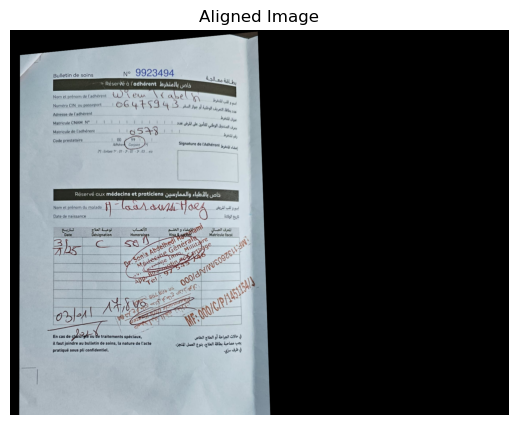

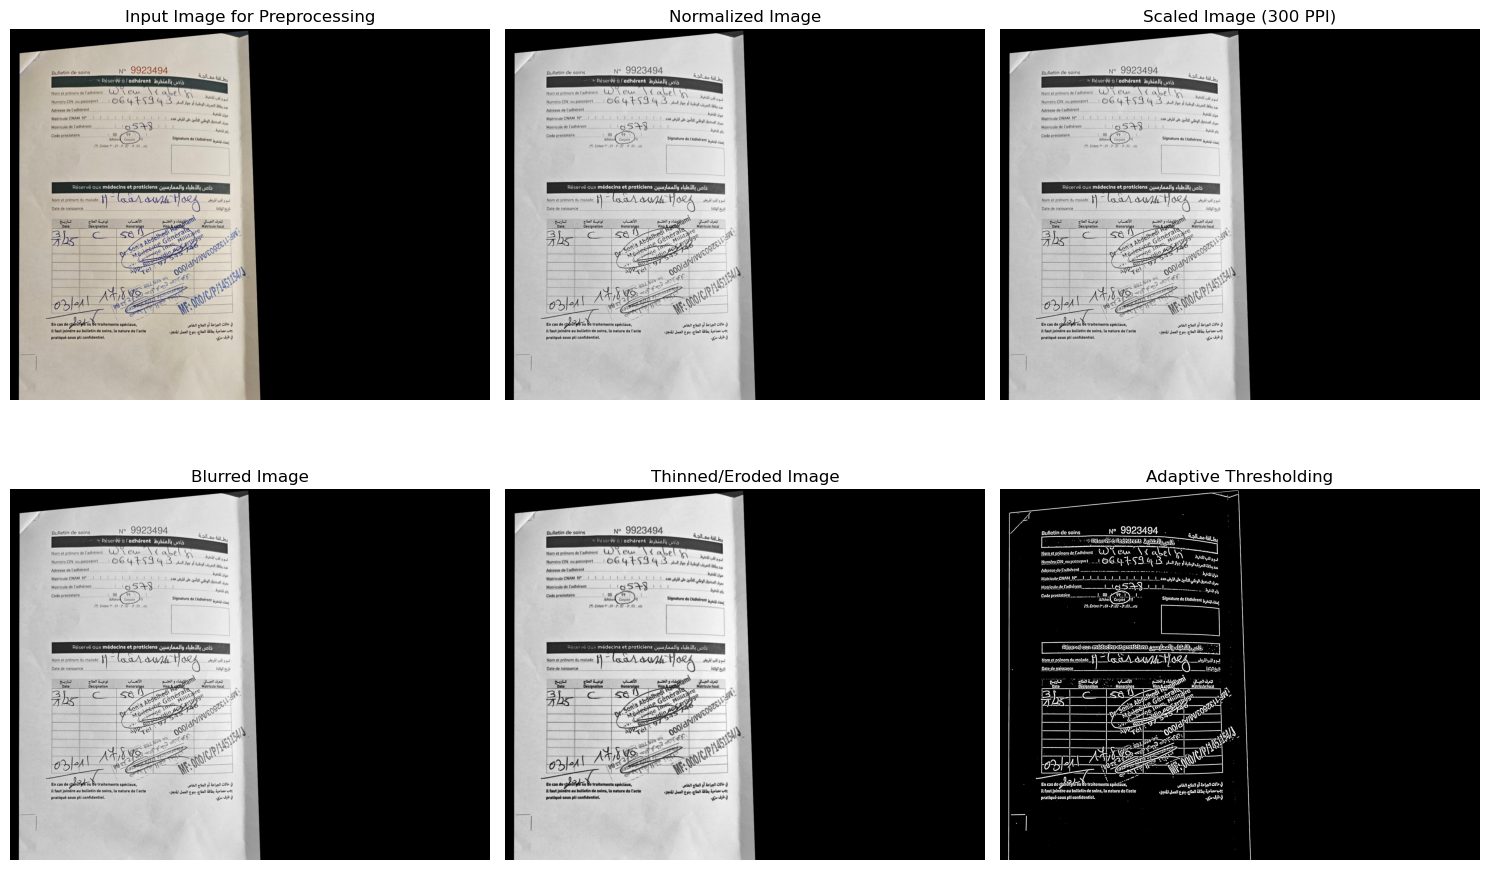

[2025/03/11 23:04:06] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\hssin/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.4, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=True, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\hssin/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch

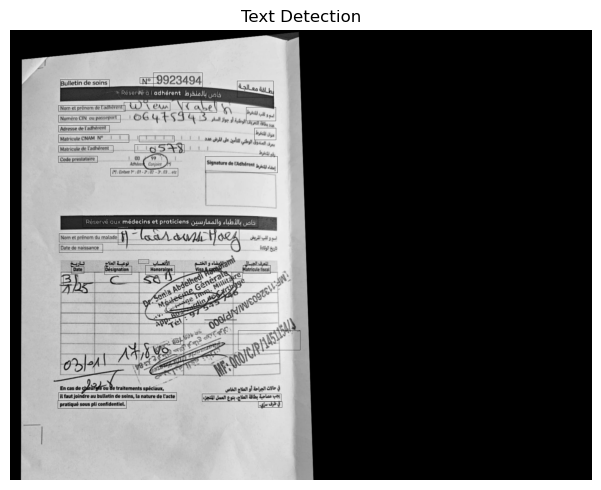

Extracted Text: [('9923494', [[1693.0, 504.0], [2279.0, 521.0], [2274.0, 673.0], [1689.0, 655.0]]), ('No ', [[1534.0, 561.0], [1735.0, 521.0], [1756.0, 630.0], [1555.0, 671.0]]), ('Bulletin de soins.', [[594.0, 585.0], [1174.0, 585.0], [1174.0, 686.0], [594.0, 686.0]]), (' aallao aLh', [[2683.0, 601.0], [3129.0, 661.0], [3111.0, 792.0], [2666.0, 732.0]]), ('.tD.1 cw', [[1346.0, 852.0], [1891.0, 852.0], [1891.0, 953.0], [1346.0, 953.0]]), ('K cbel', [[2034.0, 852.0], [2442.0, 852.0], [2442.0, 974.0], [2034.0, 974.0]]), ("Nom crprinom de.l'adherent", [[572.0, 889.0], [1358.0, 858.0], [1362.0, 959.0], [576.0, 990.0]]), ('bjall yJ sp-l', [[2790.0, 911.0], [3156.0, 971.0], [3140.0, 1073.0], [2774.0, 1013.0]]), ('Numéro.cIN_ou passeput..', [[572.0, 1004.0], [1302.0, 988.0], [1304.0, 1089.0], [574.0, 1105.0]]), ("Adresso de t'adhdient ", [[572.0, 1127.0], [1172.0, 1103.0], [1176.0, 1204.0], [576.0, 1228.0]]), ('hfWij', [[2888.0, 1157.0], [3155.0, 1194.0], [3142.0, 1297.0], [2874.0, 1259.0]]),

In [105]:
def main():
    template_folder = r"C:\Users\hssin\Downloads\template"
    new_image_path = r"C:\Users\hssin\Downloads\bulletin\bulletin\548545c0-6d1a-42c5-9433-a1a1e0f64ae9.jpeg"

    templates = load_templates_from_folder(template_folder)
    if not templates:
        print(f"No templates found in '{template_folder}'.")
        return

    new_image = cv2.imread(new_image_path)
    if new_image is None:
        print(f"Could not load image from '{new_image_path}'.")
        return
    
    best_match, best_template_name = find_best_template(new_image, templates)
    if best_match is None:
        print("No matching template found.")
        show_image(new_image, "Original Image")
        return
    
    print(f"Best template: {best_template_name}")
    aligned_image = align_image(new_image, best_match)
    
    # Preprocess with Adaptive Thresholding
    binary, original = preprocess_image(aligned_image)
    words, extracted_text = extract_text(binary, original)
    if extracted_text:
        print("Extracted Text:", extracted_text)

if __name__ == "__main__":
    main()

## Without template

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from paddleocr import PaddleOCR
import paddleocr

C:\Users\hssin\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [3]:
def show_images(images, titles, rows=1, cols=3):
    """Display multiple images in a grid with specified rows and columns."""
    # Ensure we have at least cols images by padding with None if needed
    while len(images) < cols:
        images.append(None)
        titles.append("Placeholder")
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten() if rows * cols > 1 else [axes]
    
    for img, title, ax in zip(images, titles, axes):
        if img is not None:
            ax.imshow(img if len(img.shape) == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 
                      cmap='gray' if len(img.shape) == 2 else None)
            ax.set_title(title)
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

In [5]:
def correct_rotation(image):
    """Correct the image rotation using Hough Lines or PaddleOCR's angle classification."""
    # Preprocess for better angle detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    
    # Use Hough Lines to detect rotation
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)
    angles = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
            angles.append(angle)
        
        # Calculate the median angle to avoid outliers
        median_angle = np.median(angles) if angles else 0
        print(f"Detected rotation angle (Hough Lines): {median_angle} degrees")
    else:
        median_angle = 0
        print("No lines detected for rotation correction.")
    
    images = [gray, blurred, edges]
    titles = ["Grayscale", "Blurred", "Canny Edges"]
    show_images(images, titles, rows=1, cols=3)
    
    # Apply rotation only if angle is significant
    if abs(median_angle) > 5:
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, -median_angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        images = [rotated]
        titles = ["Rotation Corrected Image"]
        show_images(images, titles, rows=1, cols=1)
        return rotated
    
    # Fallback to PaddleOCR if Hough Lines fails
    ocr = PaddleOCR(use_angle_cls=True, lang="latin", use_gpu=False)
    try:
        result = ocr.ocr(image, cls=True)
        angle = 0
        if isinstance(result, tuple) and len(result) > 1 and result[1]:
            angle_list = result[1]
            if angle_list and len(angle_list) > 0:
                angle = angle_list[0]
                print(f"Detected rotation angle (PaddleOCR): {angle} degrees")
        else:
            print("Angle classification failed or not returned by PaddleOCR.")
    except Exception as e:
        print(f"OCR angle detection error: {e}, skipping rotation.")
        angle = 0
    
    # Apply rotation only if angle is significant
    if abs(angle) > 5:
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, -angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        images = [rotated]
        titles = ["Rotation Corrected Image"]
        show_images(images, titles, rows=1, cols=1)
        return rotated
    
    show_images([image], ["Original Image (No Rotation)"], rows=1, cols=1)
    return image

In [111]:
def preprocess_image(image):
    """Preprocess the image with detailed steps and visualizations using Adaptive Thresholding."""
    images = [image, cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), None, None, None, None]
    titles = ["Input Image for Preprocessing", "Normalized Image", "Scaled Image (300 PPI)", 
              "Blurred Image", "Thinned/Eroded Image", "Adaptive Thresholding"]
    
    # Normalization
    gray = images[1] = cv2.normalize(images[1], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    
    # Image Scaling (to 300 PPI if needed)
    pil_img = Image.fromarray(gray)
    dpi = 72  # Default DPI, adjust if known
    (h, w) = gray.shape
    current_ppi = (pil_img.width / (w / dpi)) if w > 0 else 72
    if current_ppi < 300:
        scale_factor = 300 / current_ppi
        new_size = (int(pil_img.width * scale_factor), int(pil_img.height * scale_factor))
        pil_img = pil_img.resize(new_size, Image.Resampling.LANCZOS)
        images[2] = np.array(pil_img)
    else:
        images[2] = gray
    
    # Noise Removal (Gaussian Blur)
    images[3] = cv2.GaussianBlur(images[2], (5, 5), 0)
    
    # Thinning/Erosion
    kernel = np.ones((5, 5), np.uint8)
    images[4] = cv2.erode(images[3], kernel, iterations=1)
    
    # Thresholding/Binarization (Adaptive Thresholding)
    images[5] = cv2.adaptiveThreshold(images[4], 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  
                                      cv2.THRESH_BINARY_INV, 31, 5)
    
    
    images = [img for img in images if img is not None]
    titles = [title for title in titles if title != "Placeholder"]
    show_images(images, titles, rows=2, cols=3)
    
    return images[5], images[4]  

In [113]:
def extract_text(binary_image, original_image):
    """Extract text with stable OCR settings."""
    try:
        ocr = PaddleOCR(
            use_angle_cls=True,
            lang="latin",
            det_db_thresh=0.3,
            det_db_box_thresh=0.4,
            det_db_unclip_ratio=1.5,
            drop_score=0.5,
            use_dilation=True
        )
        
        result = ocr.ocr(binary_image, cls=True)
        if not result or not result[0]:
            print("No text detected by OCR.")
            show_images([original_image], ["Original Image (No Text Detected)"], rows=1, cols=1)
            return [], []
        
        # Handle result format
        result = result[0]
        extracted_text = [(line[1][0], line[0]) for line in result]
        words = [text for text, _ in extracted_text]
        boxes = [box for _, box in extracted_text]
        
        # Visualize
        vis_image = original_image.copy()
        for text, box in extracted_text:
            top_left = (int(box[0][0]), int(box[0][1]))
            bottom_right = (int(box[2][0]), int(box[2][1]))
            cv2.rectangle(vis_image, top_left, bottom_right, (0, 255, 0), 2)
            cv2.putText(vis_image, text, (top_left[0], top_left[1] - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        show_images([vis_image], ["Text Detection"], rows=1, cols=1)
        return words, extracted_text
    except Exception as e:
        print(f"OCR Error: {e}")
        show_images([original_image], ["Original Image (OCR Error)"], rows=1, cols=1)
        return [], []

Detected rotation angle (Hough Lines): 0.0 degrees


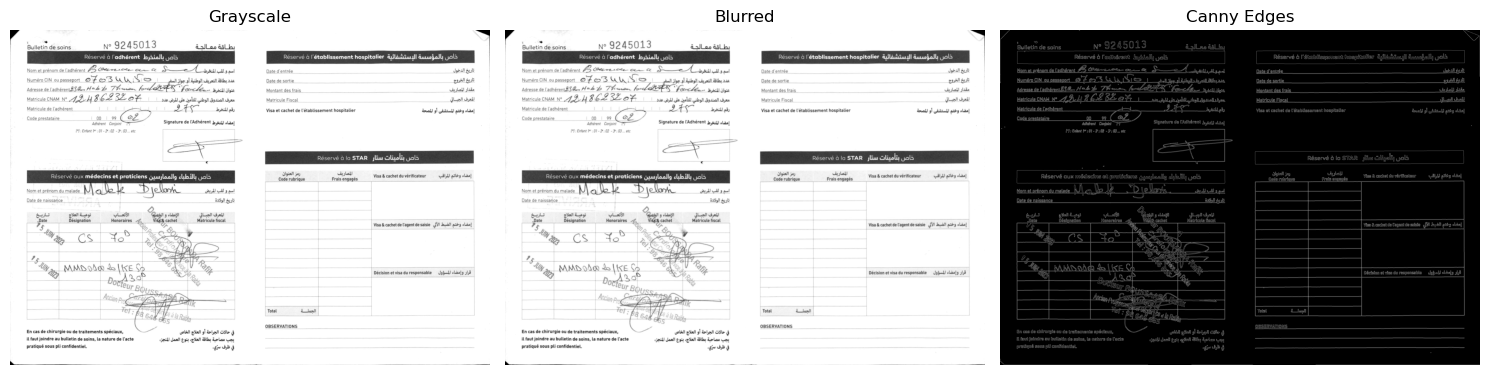

[2025/03/12 00:40:35] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\hssin/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\hssin/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batc

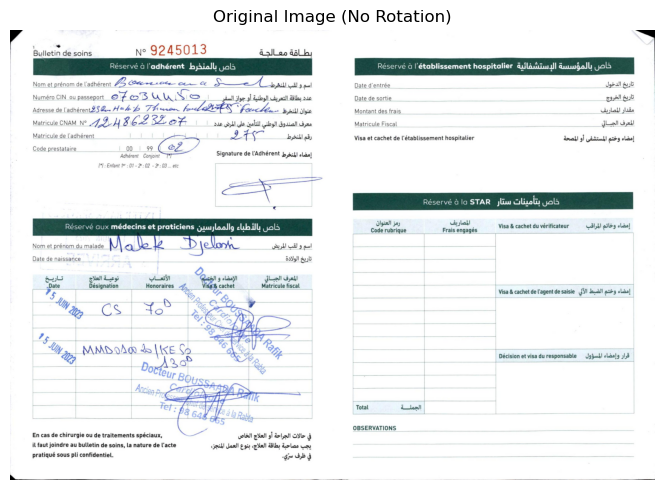

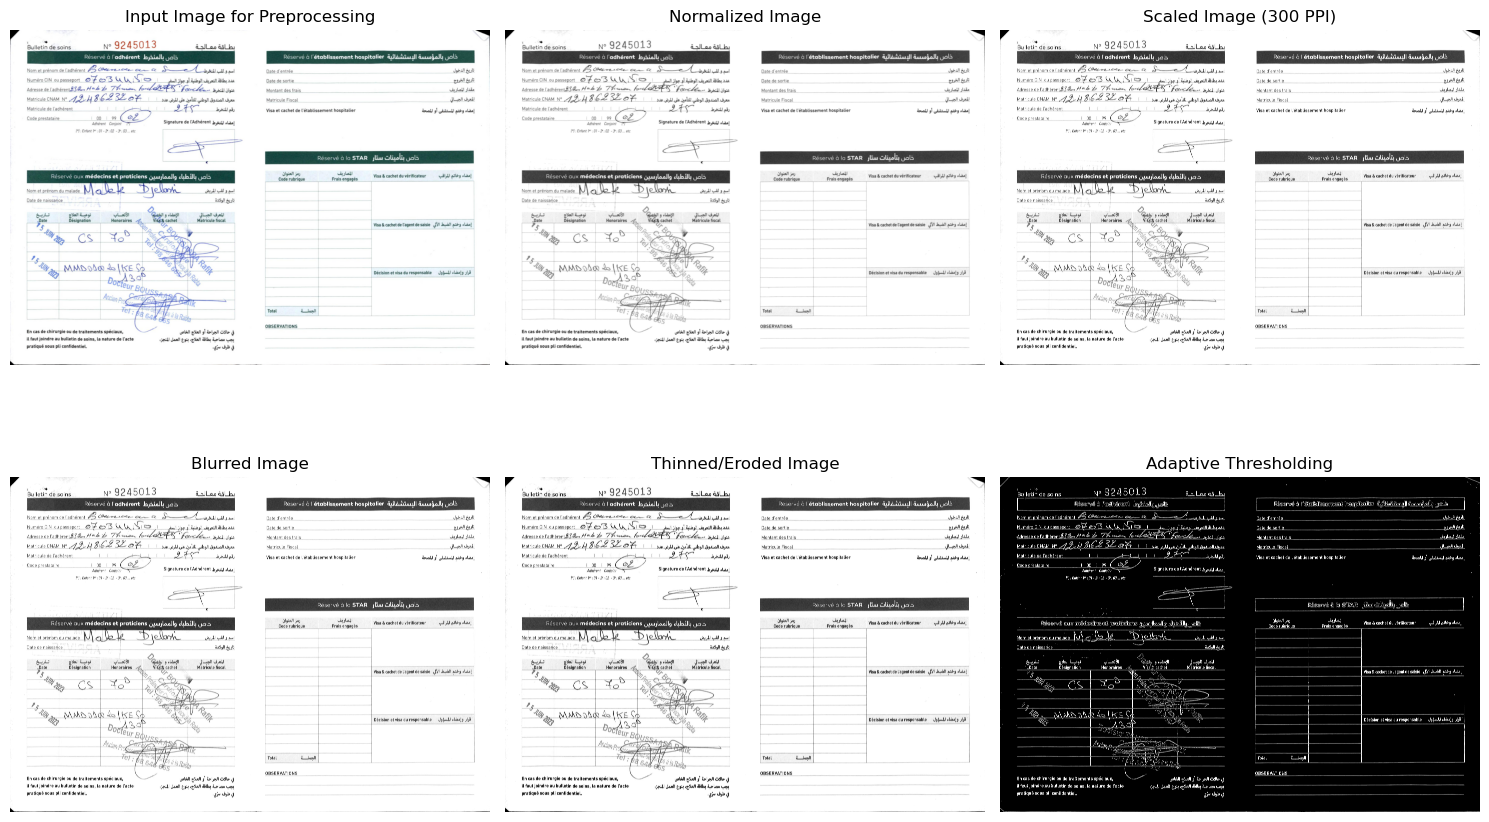

[2025/03/12 00:41:06] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\hssin/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.4, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=True, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\hssin/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch

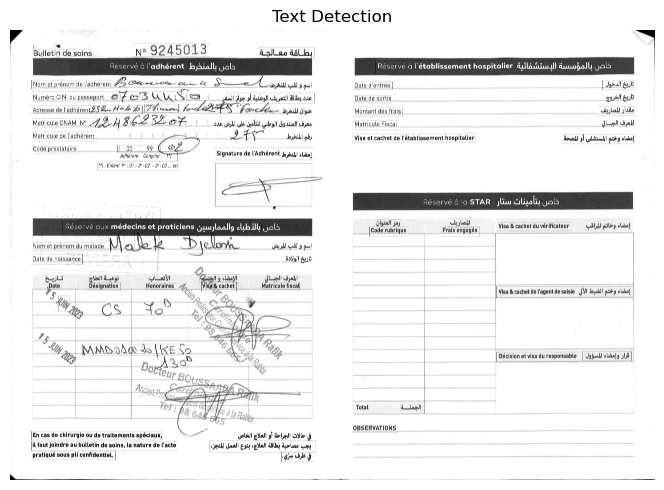

Extracted Text: [('N 9245013', [[3722.0, 414.0], [6071.0, 321.0], [6090.0, 811.0], [3742.0, 904.0]]), ('&allao alh!', [[7559.0, 531.0], [9280.0, 531.0], [9280.0, 878.0], [7559.0, 878.0]]), ('Bulletin de soins', [[676.0, 592.0], [2540.0, 592.0], [2540.0, 878.0], [676.0, 878.0]]), ("Réservé á l'adhérent hjšialu ual", [[2977.0, 834.0], [6968.0, 922.0], [6959.0, 1351.0], [2967.0, 1263.0]]), ("Réservé  I'établissement hospitalier aflarunll &nugall yab", [[11144.0, 919.0], [18416.0, 919.0], [18416.0, 1327.0], [11144.0, 1327.0]]), ("Nom et prénom de I'adhérent.", [[654.0, 1532.0], [3133.0, 1510.0], [3135.0, 1796.0], [657.0, 1818.0]]), ('Js>Jl wjL', [[18066.0, 1532.0], [19088.0, 1509.0], [19095.0, 1816.0], [18073.0, 1840.0]]), ("Date d'entrée", [[10423.0, 1576.0], [11649.0, 1528.0], [11660.0, 1814.0], [10434.0, 1862.0]]), ('Numéro CIN au passepori @i7 & B u i', [[634.0, 1879.0], [5263.0, 1837.0], [5266.0, 2185.0], [637.0, 2227.0]]), ('uljls gi ájhJljl Zlh sde', [[6554.0, 1920.0], [9278.0, 1898

In [117]:
def main():
    new_image_path = r"C:\Users\hssin\Downloads\dataset\Bulletin_de_soin\0718--9245013--20230705_page_0.jpg"

    new_image = cv2.imread(new_image_path)
    if new_image is None:
        print(f"Could not load image from '{new_image_path}'.")
        return
    
    # Correct rotation
    corrected_image = correct_rotation(new_image)
    
    # Preprocess 
    binary, original = preprocess_image(corrected_image)
    
    # Extract text
    words, extracted_text = extract_text(binary, original)
    if extracted_text:
        print("Extracted Text:", extracted_text)

if __name__ == "__main__":
    main()